# Execution Interval Method

In [1]:
import json
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import defaultdict
from libraries.utils import *
from libraries.exeint import exeInt


## Load Data

In [2]:
############ configuration ################
############################################

CODE = 'theft_protection'       ### application (code)
BEHAVIOUR_FAULTY = 'faulty_data'            ### normal, faulty_data
BEHAVIOUR_NORMAL = 'normal'            ### normal, faulty_data
THREAD = 'single'           ### single, multi
VER = 3                     ### format of data collection

base_dir = '../../trace_data' ### can be replaced with 'csv', 'exe_plot', 'histogram'
normalbase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print(normalbase_path)
print(faultybase_path)

../../trace_data/theft_protection/single_thread/version_3/normal
../../trace_data/theft_protection/single_thread/version_3/faulty_data


In [3]:

train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]



######### get paths #######################
paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

### remove.Ds_store from all lists
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

# print(paths_log)
# print(paths_traces)
# print(varlist_path)
# print(paths_label)

test_data_path = paths_traces
test_label_path = paths_label

print(train_data_path)
print(test_data_path)
print(test_label_path)


['../../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_1250_2000.json', '../../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_2050_2300.json', '../../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_150_900.json', '../../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_0_110.json']
['../../trace_data/theft_protection/single_thread/version_3/faulty_data/trace1-com', '../../trace_data/theft_protection/single_thread/version_3/faulty_data/trace2-sensor', '../../trace_data/theft_protection/single_thread/version_3/faulty_data/trace3-bitflip']
['../../trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace1-com_label.json', '../../trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace2-sensor_label.json', '../../trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace3-bitflip_label.json']


In [4]:
############# check varlist is consistent ############
############# only for version 3 ######################

if VER == 3:
    to_number = is_consistent(varlist_path)

    if to_number != False:
        from_number = mapint2var(to_number)


varlist 1 is consistent with varlist 0
{'1-0-main-g_ack': 13, '1-control-update_txmsg-0': 12, '1-0-main-lora': 2, '1-0-main-temperature': 8, '1-0-main-ow': 0, '1-0-main-events': 14, '1-0-main-com_timer': 4, '1-control-update_rxmsg-drop': 15, '1-0-loracom-data': 11, '1-control-readdata-0': 10, '1-0-main-temp': 1, '1-0-main-s': 3, '1-control-updatedata-cls.sensor_data': 9, '1-0-sense-temperature': 7, '1-0-main-i': 6, '1-control-init_timer0-0': 5} {'1-0-main-g_ack': 13, '1-control-update_txmsg-0': 12, '1-0-main-lora': 2, '1-0-main-temperature': 8, '1-0-main-ow': 0, '1-0-main-events': 14, '1-0-main-com_timer': 4, '1-control-update_rxmsg-drop': 15, '1-0-loracom-data': 11, '1-control-readdata-0': 10, '1-0-main-temp': 1, '1-0-main-s': 3, '1-control-updatedata-cls.sensor_data': 9, '1-0-sense-temperature': 7, '1-0-main-i': 6, '1-control-init_timer0-0': 5}


In [5]:
############ Get variable list ######################
sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]   ### get the variable list
# print(var_list)

## Confidence Interval

__Confidence Interval:__

A confidence interval is a range around the mean that is likely to contain the true population mean. The formula for a confidence interval is mean ± margin of error mean±margin of error, where the margin of error depends on the desired confidence level and the standard error.

_Example:_

1. Choose a confidence level (e.g., 95%).
2. Calculate the standard error: standard deviation/ sqr_root(number of observations)
3. Calculate the margin of error: critical value × standard error
4. Determine the confidence interval: mean ± margin of error


In [6]:
### initialize exeinz
ei = exeInt()

### Data Processing

In [7]:
### get execution intervals for all variables

exe_list, filewise_exe_list = ei.get_exeint(train_data_path)

../../trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_1250_2000.json
dict_keys([13, 14, 15, 6, 7, 8, 9, 10, 11, 12])
13 253738 257970
13 257970 263253
13 263253 268536
13 268536 273818
13 273818 278049
13 278049 283332
13 283332 288613
13 288613 293898
13 293898 298131
13 298131 303414
13 303414 308697
13 308697 312929
13 312929 318213
13 318213 323495
13 323495 328781
13 328781 333012
13 333012 338295
13 338295 343579
13 343579 348864
13 348864 353097
13 353097 358381
13 358381 363664
13 363664 367898
13 367898 373183
13 373183 378469
13 378469 383751
13 383751 387987
13 387987 393270
13 393270 398554
13 398554 403839
14 253743 257974
14 257974 263257
14 263257 268540
14 268540 273822
14 273822 278053
14 278053 283337
14 283337 288619
14 288619 293903
14 293903 298135
14 298135 303418
14 303418 308701
14 308701 312934
14 312934 318217
14 318217 323500
14 323500 328786
14 328786 333017
14 333017 338300
14 338300 343584
14 343584 348868
14 348868 353101
14

In [8]:
### get the confidence intervals for all variables
# confidence_intervals = ei.get_confinterval(exe_list)

############ calculate dynamic thresholds ############
thresholds = ei.get_dynamicthresh(exe_list)

13
dict_keys([5.29, 4.23, 5.28, 4.24])
0.2
0.23333333333333334
0.5333333333333333
0.03333333333333333
14
dict_keys([5.29, 4.23, 5.28, 4.24])
0.13333333333333333
0.2
0.6
0.06666666666666667
15
dict_keys([5.29, 4.23, 5.28, 4.24])
0.1724137931034483
0.2413793103448276
0.5517241379310345
0.034482758620689655
6
dict_keys([1.05, 1.07, 1.06])
0.5815602836879432
0.09929078014184398
0.3191489361702128
7
dict_keys([1.05, 1.07, 1.06])
0.5815602836879432
0.11347517730496454
0.3049645390070922
8
dict_keys([1.05, 1.06, 1.07])
0.5815602836879432
0.2907801418439716
0.1276595744680851
9
dict_keys([1.05, 1.06, 1.07])
0.5815602836879432
0.3049645390070922
0.11347517730496454
10
dict_keys([5.29, 4.23, 5.28, 4.24])
0.20689655172413793
0.20689655172413793
0.5517241379310345
0.034482758620689655
11
dict_keys([5.29, 4.23, 5.28, 4.24])
0.2413793103448276
0.20689655172413793
0.5172413793103449
0.034482758620689655
12
dict_keys([5.29, 4.23, 5.28, 4.24])
0.20689655172413793
0.20689655172413793
0.5517241379310345


In [9]:
thresholds

{13: [4.1, 5.4],
 14: [4.1, 5.4],
 15: [4.1, 5.4],
 6: [1.0, 1.2],
 7: [1.0, 1.2],
 8: [1.0, 1.2],
 9: [1.0, 1.2],
 10: [4.1, 5.4],
 11: [4.1, 5.4],
 12: [4.1, 5.4]}

In [10]:
### visualize the thresholds for varlist
for key in thresholds.keys():
    print(from_number[key], ':', end=' ')
    print(thresholds[key], end=', ')
    print('\n')

1-0-main-g_ack : [4.1, 5.4], 

1-0-main-events : [4.1, 5.4], 

1-control-update_rxmsg-drop : [4.1, 5.4], 

1-0-main-i : [1.0, 1.2], 

1-0-sense-temperature : [1.0, 1.2], 

1-0-main-temperature : [1.0, 1.2], 

1-control-updatedata-cls.sensor_data : [1.0, 1.2], 

1-control-readdata-0 : [4.1, 5.4], 

1-0-loracom-data : [4.1, 5.4], 

1-control-update_txmsg-0 : [4.1, 5.4], 



### Visualising Thresholds

In [11]:
#### plot exe_list to vsiualize the distribution of execution intervals
ei.viz_thresholds(exe_list, thresholds=thresholds)


### Validation

In [12]:
#### Detect anomalies in faulty traces
DIFF_VAL = 1
all_tp = []
all_fp = []
all_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]  
y_pred_all = []
y_true_all = []
for test_data, test_label in zip(test_data_path, test_label_path):
    print(test_data, test_label)
    detection = ei.test_single(test_data, thresholds)   ### detection in format: [var, (ts1,ts2), file_name]
    dedup_detection, grouped_det = ei.remove_duplicates(detection, DIFF_VAL)  ### remove multiple detections for single ground truth
    detection = dedup_detection
    all_detections += [(test_data, detection, test_label)]  ### used to plot detections

    ### load ground truths
    ground_truth_raw = read_traces(test_label)
    ground_truth = ground_truth_raw['labels']
    label_trace_name = list(ground_truth.keys())[0]
    ground_truth = ground_truth[label_trace_name]
    print('ground truths:', ground_truth)
    print(len(ground_truth))

    # correct_pred, rest_pred, y_pred, y_true = get_ypred_ytrue(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred
    correct_pred, rest_pred, y_pred, y_true = ei.get_correct_detections(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred

    assert( len(detection) == len(correct_pred) + len(rest_pred) )

    all_tp += [(test_data, correct_pred, test_label)]
    all_fp += [(test_data, rest_pred, test_label)]

    y_pred_all.extend(y_pred)
    y_true_all.extend(y_true)

    # break

../../trace_data/theft_protection/single_thread/version_3/faulty_data/trace1-com ../../trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace1-com_label.json
Anomaly detected for 13 in trace1-com at 227th event
Execution interval: 14.8
Anomaly detected for 14 in trace1-com at 228th event
Execution interval: 14.8
Anomaly detected for 15 in trace1-com at 229th event
Execution interval: 14.8
Anomaly detected for 13 in trace1-com at 350th event
Execution interval: 10.6
Anomaly detected for 14 in trace1-com at 351th event
Execution interval: 10.6
Anomaly detected for 15 in trace1-com at 352th event
Execution interval: 10.6
Anomaly detected for 13 in trace1-com at 447th event
Execution interval: 10.6
Anomaly detected for 14 in trace1-com at 448th event
Execution interval: 10.6
Anomaly detected for 15 in trace1-com at 449th event
Execution interval: 10.6
Anomaly detected for 13 in trace1-com at 563th event
Execution interval: 14.8
Anomaly detected for 14 in trace1-com at

In [13]:
correct_pred

[[(14, 0), (28336, 29401), 'trace3-bitflip'],
 [(14, 0), (29401, 30461), 'trace3-bitflip'],
 [(14, 0), (30461, 31521), 'trace3-bitflip'],
 [(14, 0), (31521, 32594), 'trace3-bitflip'],
 [(14, 0), (33655, 34719), 'trace3-bitflip'],
 [(14, 0), (34719, 35779), 'trace3-bitflip'],
 [(14, 0), (35779, 36839), 'trace3-bitflip'],
 [(14, 0), (36839, 37912), 'trace3-bitflip'],
 [(14, 0), (37912, 38974), 'trace3-bitflip'],
 [(14, 0), (40034, 41098), 'trace3-bitflip'],
 [(14, 0), (41098, 42173), 'trace3-bitflip'],
 [(14, 0), (43233, 44297), 'trace3-bitflip'],
 [(14, 0), (44297, 45358), 'trace3-bitflip'],
 [(14, 0), (45358, 46418), 'trace3-bitflip'],
 [(14, 0), (46418, 47492), 'trace3-bitflip'],
 [(14, 0), (48552, 49617), 'trace3-bitflip'],
 [(14, 0), (49617, 50677), 'trace3-bitflip'],
 [(14, 0), (50677, 51737), 'trace3-bitflip'],
 [(14, 0), (51737, 52812), 'trace3-bitflip'],
 [(14, 0), (53872, 54938), 'trace3-bitflip'],
 [(14, 0), (54938, 55998), 'trace3-bitflip'],
 [(14, 0), (55998, 57071), 'trace3

In [14]:
rest_pred

[[(14, 0), (32594, 33655), 'trace3-bitflip'],
 [(14, 0), (38974, 40034), 'trace3-bitflip'],
 [(14, 0), (42173, 43233), 'trace3-bitflip'],
 [(14, 0), (47492, 48552), 'trace3-bitflip'],
 [(14, 0), (52812, 53872), 'trace3-bitflip'],
 [(14, 0), (57071, 58131), 'trace3-bitflip'],
 [(11, 0), (152177, 158339), 'trace3-bitflip'],
 [(14, 0), (153243, 159405), 'trace3-bitflip'],
 [(14, 0), (163637, 169176), 'trace3-bitflip'],
 [(8, 0), (168908, 170228), 'trace3-bitflip'],
 [(14, 0), (178696, 184232), 'trace3-bitflip'],
 [(8, 0), (183967, 185286), 'trace3-bitflip'],
 [(8, 0), (202188, 203505), 'trace3-bitflip'],
 [(14, 0), (242667, 243728), 'trace3-bitflip'],
 [(14, 0), (247989, 249049), 'trace3-bitflip'],
 [(14, 0), (252248, 253309), 'trace3-bitflip'],
 [(14, 0), (257569, 258630), 'trace3-bitflip'],
 [(14, 0), (262890, 263950), 'trace3-bitflip'],
 [(14, 0), (267149, 268210), 'trace3-bitflip'],
 [(14, 0), (270337, 273515), 'trace3-bitflip'],
 [(14, 0), (283034, 288561), 'trace3-bitflip'],
 [(8, 0

Precision: 0.7079
Recall: 1.0000
F1 Score: 0.8290
Confusion Matrix:
[[  0  59]
 [  0 143]]


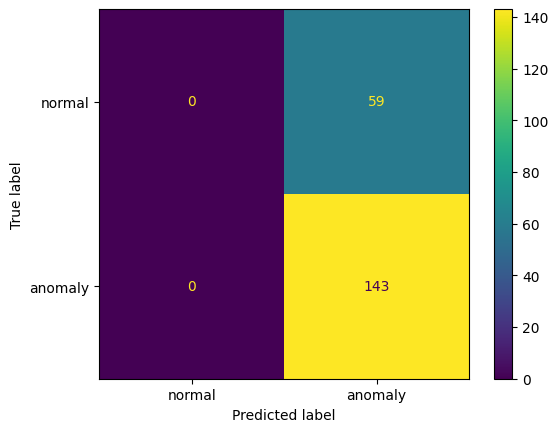

In [15]:
### Evaluation metrics

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, average_precision_score, ConfusionMatrixDisplay


# Calculate precision
precision = precision_score(y_true_all, y_pred_all)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_true_all, y_pred_all)
print(f'Recall: {recall:.4f}')

# # Calculate average precision
# average_precision = average_precision_score(y_true_all, y_pred_all)
# print(f'Average Precision: {average_precision:.4f}')

# Calculate F1 score
f1 = f1_score(y_true_all, y_pred_all)
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:")
print(conf_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['normal', 'anomaly'])
disp.plot()

In [ ]:
all_fp

## Plot Detections

In [16]:
### plot gt and detections
# for test_data, detections, test_label in all_detections:
for test_data, detections, test_label in all_fp:
    # print('test_data:', test_data)
    # print('detections:', detections)
    # print(test_label)

    ### prepare trace to plot
    col_data = preprocess_traces([test_data])
    all_df = get_dataframe(col_data) 
    # print(all_df[0])

    ### prepare detections to plot
    timestamps = col_data[0][1]
    print('timestamps:', timestamps)
    plot_val = []
    plot_x_ticks = []
    plot_class = []
    for det in detections:
        # print(det)
        det_ts1, det_ts2 = det[1]
        # print(det_ts1, det_ts2)

        det_ind1_pre = [ abs(t-det_ts1) for t in timestamps]
        det_ind1 = det_ind1_pre.index(min(det_ind1_pre))

        det_ind2_pre = [ abs(t-det_ts2) for t in timestamps]
        det_ind2 = det_ind2_pre.index(min(det_ind2_pre))
        # print(det_ind1, det_ind2)
        # print(timestamps[det_ind1], timestamps[det_ind2])

        plot_val += [(det_ind1, det_ind2)]
        plot_x_ticks += [(timestamps[det_ind1], timestamps[det_ind2])]
        plot_class += [0]

    plot_detections = [plot_val, plot_x_ticks, plot_class]

    ### get ground truths
    gt_plot = prepare_gt(test_label)

    ### plot
    for df in all_df:
        # print(df.columns)
        plot_single_trace(df, 
                          var_list, 
                          with_time=False, 
                          is_xticks=True, 
                          detections=plot_detections, 
                          dt_classlist=['detection'],
                          ground_truths=gt_plot,
                          gt_classlist=['gt_communication', 'gt_sensor', 'gt_bitflip'],
                          )

    # break

../../trace_data/theft_protection/single_thread/version_3/faulty_data/trace1-com trace1-com
timestamps: [1307, 1335, 1356, 1361, 1869, 1874, 1877, 1903, 2919, 2924, 2928, 2953, 3970, 3975, 3979, 4004, 5021, 5025, 5030, 5055, 6071, 6076, 6080, 6105, 7122, 7127, 7130, 7135, 7140, 7145, 7170, 8187, 8191, 8195, 8200, 8204, 8209, 8234, 9250, 9255, 9259, 9284, 10301, 10305, 10310, 10335, 11352, 11356, 11361, 11386, 12403, 12408, 12411, 12416, 12421, 12425, 12450, 13467, 13472, 13476, 13480, 13484, 13488, 13514, 14530, 14534, 14539, 14564, 15580, 15585, 15589, 15614, 16631, 16636, 16640, 16665, 17682, 17687, 17690, 17696, 17700, 17705, 17730, 18747, 18751, 18756, 18760, 18764, 18769, 18794, 19810, 19815, 19819, 19844, 20861, 20866, 20870, 20895, 21912, 21917, 21920, 21925, 21930, 21934, 21960, 22976, 22981, 22985, 22990, 22994, 22999, 23025, 24041, 24046, 24050, 24075, 25092, 25096, 25101, 25126, 26143, 26147, 26152, 26178, 27194, 27199, 27202, 27207, 27212, 27217, 27243, 28259, 28264, 28268,

../../trace_data/theft_protection/single_thread/version_3/faulty_data/trace2-sensor trace2-sensor
timestamps: [1351, 1379, 1400, 1405, 1913, 1917, 1921, 1947, 2964, 2968, 2973, 2998, 4015, 4019, 4023, 4048, 5065, 5069, 5073, 5099, 6116, 6120, 6124, 6149, 7167, 7171, 7175, 7180, 7185, 7190, 7215, 8232, 8236, 8240, 8266, 9283, 9287, 9291, 9296, 9300, 9305, 9330, 10347, 10351, 10355, 10380, 11397, 11401, 11405, 11431, 12448, 12452, 12456, 12461, 12465, 12470, 12495, 13513, 13517, 13521, 13526, 13529, 13534, 13559, 14576, 14580, 14584, 14610, 15627, 15631, 15635, 15661, 16678, 16682, 16686, 16712, 17729, 17733, 17737, 17742, 17747, 17751, 17776, 18794, 18798, 18802, 18807, 18810, 18815, 18841, 19858, 19862, 19866, 19892, 20909, 20913, 20917, 20942, 21959, 21963, 21967, 21972, 21977, 21981, 22007, 23024, 23028, 23032, 23037, 23041, 23046, 23071, 24088, 24092, 24096, 24121, 25139, 25143, 25147, 25173, 26190, 26194, 26199, 26224, 27241, 27245, 27249, 27254, 27259, 27263, 27289, 28306, 28310, 

../../trace_data/theft_protection/single_thread/version_3/faulty_data/trace3-bitflip trace3-bitflip
timestamps: [1369, 1397, 1418, 1423, 1931, 1935, 1939, 1964, 2981, 2985, 2990, 3015, 4032, 4036, 4040, 4065, 5083, 5087, 5091, 5116, 6132, 6137, 6141, 6166, 7183, 7187, 7190, 7196, 7201, 7205, 7231, 8248, 8252, 8257, 8261, 8265, 8270, 8295, 9312, 9316, 9320, 9346, 10363, 10367, 10371, 10396, 11414, 11418, 11423, 11448, 12464, 12469, 12472, 12477, 12482, 12487, 12512, 13529, 13533, 13537, 13542, 13545, 13550, 13575, 14593, 14597, 14602, 14627, 15643, 15648, 15652, 15677, 16694, 16698, 16702, 16727, 17745, 17749, 17752, 17757, 17762, 17767, 17792, 18810, 18814, 18819, 18823, 18827, 18832, 18857, 19874, 19878, 19882, 19908, 20925, 20929, 20933, 20958, 21976, 21980, 21983, 21988, 21993, 21998, 22023, 23041, 23045, 23050, 23054, 23058, 23063, 23088, 24105, 24109, 24113, 24139, 25156, 25160, 25164, 25189, 26207, 26211, 26215, 26240, 27258, 27262, 27265, 27271, 27275, 27280, 27306, 28323, 28327

In [ ]:
2090

In [ ]:
1890

Observations
---
- since multiple variables are affected due to single anomaly, multiple detections are generated for each anomaly.
- This leads to multiple FP.
- To avoid this, we implement deduplication which groups the detections that are close to each other bsed on timestamp
- However, in this process along with decrease in FP, we have more False Negatives i.e. some anomalies are not detected. 

TODO:
- change deduplication stratergy, if possible